In [1]:
import numpy as np

from Analysis_utils import *
from Plots import *
from scipy.interpolate import CubicSpline

# 3D Embedding

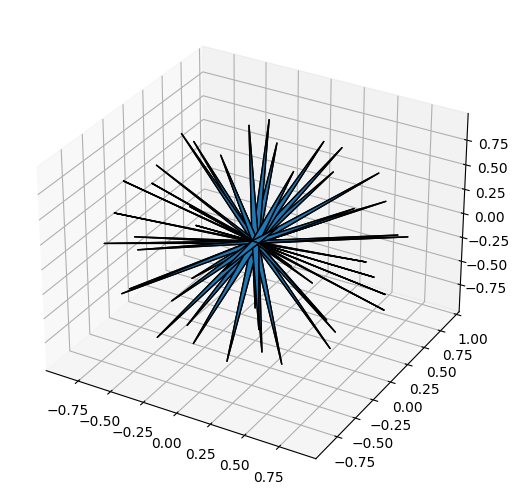

In [2]:
m = Manifold(100)
plot_triangulation_3d(m.adj)

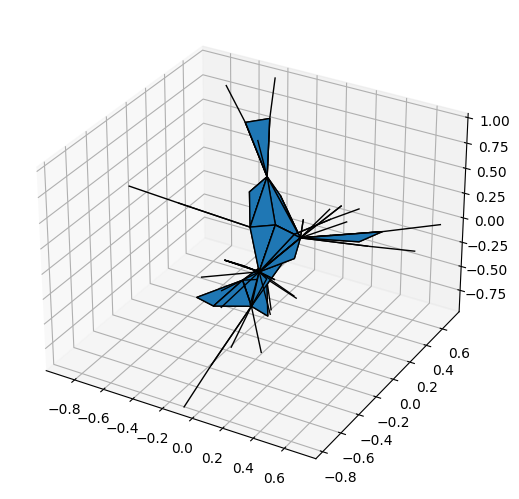

In [3]:
n_sweeps = 30
m.sweep(n_sweeps, 0.1, strategy=['gravity', 'spinor', 'scalar'])
plot_triangulation_3d(m.adj)

In [4]:
%time m.sweep(n_sweeps, 0.1, strategy=['gravity', 'spinor'])

CPU times: user 4.09 s, sys: 0 ns, total: 4.09 s
Wall time: 4.09 s


In [5]:
%time m.sweep(n_sweeps, 0.1, strategy=['gravity', 'spinor'], fast=True)

CPU times: user 2.11 s, sys: 2.98 ms, total: 2.11 s
Wall time: 2.11 s


In [6]:
%time m.sweep(n_sweeps, 0.1, strategy=['gravity'], fast=True)
%time m.sweep(n_sweeps, 0.1, strategy=['gravity'])

CPU times: user 86.2 ms, sys: 6.64 ms, total: 92.9 ms
Wall time: 90.3 ms


/home/mgv29/Desktop/Internship 2022/Lattice Gravity/Lattice Gravity Code/2D_QG/Triangulation.py:199: RuntimeWarning: overflow encountered in exp
  p = np.exp(-b * dS)


CPU times: user 2.03 s, sys: 30 µs, total: 2.03 s
Wall time: 2.02 s


In [4]:
A = m.A
psi = m.psi

j = 10
c = 4
adj_c = 20
theta = 1

def ex1():
    U = paral_trans(A[j])
    d_psi_0 = U[0, 0] * psi[adj_c, 0] + U[0, 1] * psi[adj_c, 1] - psi[c, 0]
    d_psi_1 = U[0, 0] * psi[adj_c, 1] + U[1, 1] * psi[adj_c, 1] - psi[c, 1]
    d_psi = np.array([d_psi_0, d_psi_1])
def ex2():
    d_psi = (np.matmul(paral_trans(A[j]), psi[adj_c]) - psi[c])

In [5]:
%timeit S_psi(m.adj, psi, c, A)
%timeit S_phi(m.adj, m.phi, c)

70.9 µs ± 3.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
6.34 µs ± 452 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
%timeit ex1()
%timeit ex2()

7.05 µs ± 41.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.57 µs ± 88.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
is_sphere_triangulation(m.adj)

True

# Distance Profile and Haussdorff Dimension (pure gravity)

In [8]:
beta=0
sizes = np.array([2*int(i) for i in np.geomspace(10, 20, 3)])
profiles = make_profiles(beta, sizes, strategy=['gravity'])
plot_profiles(profiles, sizes)

20


KeyboardInterrupt: 

In [ ]:
d_Haussdorf = 4
xs, ys = scale_profile(profiles, sizes, 1/d_Haussdorf)
overlay_profiles(ys, xs, sizes)

# Finite size scaling

In [9]:
def scale_profile(profiles, sizes, d):
    xs, ys = [], []
    for i, profile in enumerate(profiles):
        rvals = np.arange(len(profile))
        x = rvals / sizes[i] ** d
        y = profile / sizes[i] ** (1 - d)
        xs.append(x), ys.append(y)
        # plt.plot(x, y)
    return np.array(xs), np.array(ys)

def profiles_max(profiles):
    profiles_max = np.max(profiles, axis=1)
    return profiles_max[:,0], profiles_max[:,1]

def power_fit(N, d, a):
    return a*N**d

def lin_fit(x, d, b):
    return b + d*x

def finite_size_scaling(profile, sizes):
    prof_max, sigma_max = profiles_max(profile)
    fit = curve_fit(power_fit, sizes, prof_max, p0=[0.75, 1])
    (d, a), err = fit
    d_H = 1/(1-d)
    d_err = np.sqrt(err[0,0])
    d_H_err = d_H**2*d_err
    a_err = np.sqrt(err[1,1])
    return d_H, d_H_err, a, a_err

def finite_size_scaling_fit(profile, sizes):
    prof_max = np.max(profile, axis=1)
    fit = curve_fit(power_fit, sizes, prof_max, p0=[0.75, 1])
    (d, a), err = fit
    d_H = 1/(1-d)
    d_err = np.sqrt(err[0,0])
    d_H_err = d_H**2*d_err
    a_err = np.sqrt(err[1,1])
    return d_H, d_H_err, a, a_err

20
26
36
50
70


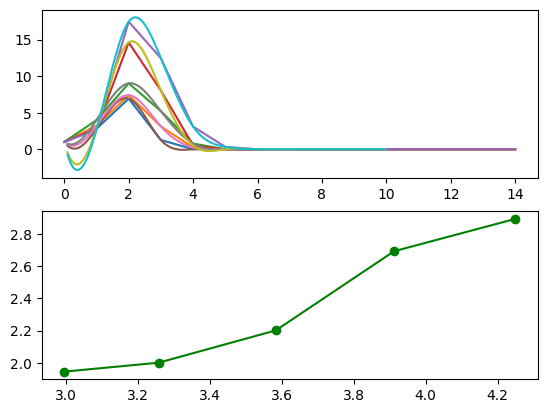

In [11]:
beta=0.4
sizes = [(int(i)//2)*2 for i in np.geomspace(20, 70, 5)]

prof = make_profiles(beta, sizes, meas_sweeps=2, strategy=['gravity', 'spinor'])


prof_0 = prof[..., 0]
rs0 = np.arange
rs = np.arange(0.1, 10, 0.05)
fit_prof = []


fig, ax = plt.subplots(2)
for profile in prof_0:
    dist_range = range(len(profile))
    cs = CubicSpline(dist_range, profile)
    fit_prof.append(cs(rs))
    ax[0].plot(dist_range, profile)

for p in fit_prof:
    ax[0].plot(rs, p)

y = np.log(np.max(fit_prof, axis=1))
x = np.log(sizes)
ax[1].plot(x, y, 'go-')

np.savez('profiles_spinor_1', full_prof=prof, fit_prof=np.array(fit_prof), prof_0=prof_0, sizes=sizes, beta=beta)

In [12]:
s = slice(0, None)
sizes = np.load('profiles_spinor_1.npz')['sizes'][s]
fit_prof = np.load('profiles_spinor_1.npz')['fit_prof'][s]
prof = np.load('profiles_spinor_1.npz')['full_prof'][s]

y = np.log(np.max(fit_prof, axis=1))
x = np.log(sizes)

fit = curve_fit(lin_fit, x, y, p0=[0.75, 0])
(d, a), err = fit
d_H = 1/(1-d)
d_err = np.sqrt(err[0,0])
d_H_err = d_H**2*d_err
a_err = np.sqrt(err[1,1])

print("\nwith spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

d_H, d_H_err, a, a_err = finite_size_scaling(prof, sizes)
print("\nwithout spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')


with spline fit:
d_H = 5.733442931698055+/-d_H_err = 3.7397499875713693
a = -0.6250972340649793+/-a_err = 0.4126572910626526

without spline fit:
d_H = 6.07824021901142+/-d_H_err = 3.9006199764243963
a = 0.5105727183571335+/-a_err = 0.2116848050996258


min_d = 6.0
min_err = 0.01800859719907373


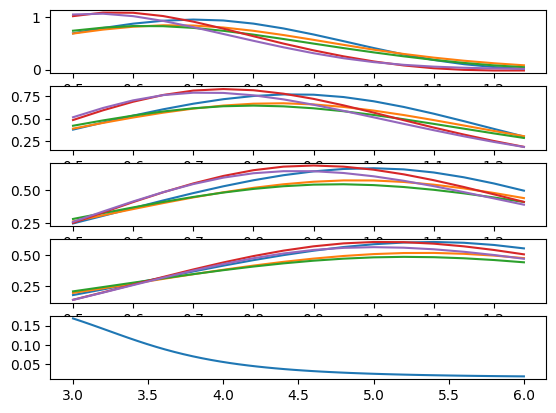

In [14]:
# CHECK ACCEPTANCE RATE OF ISING MOVES.
# RESCALE SPLINES SO THAT THEY HAVE SAME SIZE


steps = 50
n_plots = 4
fig, ax = plt.subplots(n_plots+1)

s = slice(0, None)
prof = np.load('profiles_spinor_1.npz')['full_prof'][s]

ds = np.linspace(3, 6, steps)
x_range = np.arange(0.5, 1.3, 0.05)
errors = []
min_err = np.inf
min_d = 0
for i, d in enumerate(ds):
    splines = []
    xs, ys = scale_profile(prof, sizes, 1/d)
    ys = ys[..., 0]
    for x, y in zip(xs, ys):
        cs = CubicSpline(x, y)
        splines.append(cs(x_range))

        interval = int(np.ceil(steps/n_plots))
        if i%interval==0:
            ax[i//interval].plot(x_range, cs(x_range))

    splines = np.array(splines)
    err_spline = np.sum(np.var(splines, axis=0))
    if err_spline < min_err:
        min_err = err_spline
        min_d = d
    errors.append(err_spline)


print(f'{min_d = }')
print(f'{min_err = }')
ax[-1].plot(ds, errors)

In [ ]:
sizes = [(int(i)//2)*2 for i in np.geomspace(100, 1000, 10)]
fit_prof = np.load('profiles_beta_1.npz')['fit_prof']
prof = np.load('profiles_beta_1.npz')['full_prof']
xs, ys = scale_profile(prof, sizes, 1/4)

In [ ]:
d = 3.5
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs, sizes)

In [ ]:
d = 4
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs, sizes)

In [19]:
%time U = scipy.linalg.expm(eps)
%time U = np.cos(1)*np.identity(2) + np.sin(1)*eps

CPU times: user 477 µs, sys: 0 ns, total: 477 µs
Wall time: 512 µs
CPU times: user 67 µs, sys: 0 ns, total: 67 µs
Wall time: 70.8 µs


In [27]:
a = np.ones((2,2))
b = np.array([1, 4])
%timeit c = np.matmul(a, b)
%timeit d = np.array([a[0,0]*b[0]+a[0,1]*b[1], a[1,0]*b[0]+a[1,1]*b[1]])

1.42 µs ± 12 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.6 µs ± 44.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
